In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml
import json
import pickle
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmse
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
seed = 1019

settings = yaml.safe_load(f'''
name: '236_old_platform_scores'
competition: atmacup8
description: ''
seed: {seed}
training:
    pca_dim: 4
    validation: 'group'
    num_folds: 5
    num_rounds: 10000
    early_stopping_rounds: 1000
    verbose_eval: 20
    sample_weight_division: 0.01  # 10/2/1
    sample_weight_threshold: 1000
feature:
    name_bow_pca_dim: 4
    name_bow_word_th1: 5
    name_bow_word_th2: 3
    name_bow_th1_upper: 130
    name_bow_th2_upper: 100
lgbm_params:
    # seed: {seed}
    objective: regression
    learning_rate: 0.01
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')
print(json.dumps(settings, indent=4))

{
    "name": "236_old_platform_scores",
    "competition": "atmacup8",
    "description": "",
    "seed": 1019,
    "training": {
        "pca_dim": 4,
        "validation": "group",
        "num_folds": 5,
        "num_rounds": 10000,
        "early_stopping_rounds": 1000,
        "verbose_eval": 20,
        "sample_weight_division": 0.01,
        "sample_weight_threshold": 1000
    },
    "feature": {
        "name_bow_pca_dim": 4,
        "name_bow_word_th1": 5,
        "name_bow_word_th2": 3,
        "name_bow_th1_upper": 130,
        "name_bow_th2_upper": 100
    },
    "lgbm_params": {
        "objective": "regression",
        "learning_rate": 0.01,
        "max_depth": -1,
        "num_leaves": 31,
        "colsample_bytree": 0.7,
        "metric": "None"
    }
}


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'country_prob_train_old.csv')
df_test = pd.read_csv(datadir / 'country_prob_test_old.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 21), (8360, 16))

In [6]:
df_train.iloc[165:172]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_na_sales,has_eu_sales,has_jp_sales,has_other_sales
165,Hogan's Alley,NES,1984.0,Shooter,Nintendo,68,16,41,2,127,...,NaN,NaN,NaN,NaN,NaN,165,0.850414,0.841799,0.954037,0.679003
166,Golf,NES,1984.0,Sports,Nintendo,122,28,246,4,401,...,NaN,NaN,NaN,NaN,NaN,166,0.915229,0.899803,0.901652,0.778524
167,Tennis,NES,1984.0,Sports,Nintendo,48,11,156,2,217,...,NaN,NaN,NaN,NaN,NaN,167,0.914235,0.893165,0.902716,0.732968
168,Kung Fu,NES,1985.0,Action,Nintendo,164,38,142,6,350,...,NaN,NaN,NaN,NaN,NaN,168,0.904925,0.878382,0.956726,0.764878
169,Strongest Tokyo University Shogi DS,DS,1985.0,Action,Mycom,0,0,2,0,2,...,NaN,NaN,NaN,NaN,NaN,169,0.582439,0.312827,0.773832,0.187524
170,Super Mario Bros.,NES,1985.0,Platform,Nintendo,2908,358,681,77,4024,...,NaN,NaN,NaN,NaN,NaN,170,0.915843,0.918814,0.963002,0.916682
171,Ice Climber,NES,1985.0,Platform,Nintendo,46,10,92,2,150,...,NaN,NaN,NaN,NaN,NaN,171,0.823405,0.818339,0.975746,0.777310


In [7]:
# target や weight の用意
target_column = 'Global_Sales'
train_target_columns = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for c in train_target_columns:
    df_train.loc[:, 'mod_' + c] = df_train.loc[:, c].apply(lambda x: np.log1p(x))
df_train['target'] = df_train.loc[:, f'mod_{target_column}']

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df_base_train = df_train.loc[:, ['id']]
df_base_test = df_test.loc[:, ['id']]

train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

In [9]:
from mykaggle.feature.le import LE
from mykaggle.feature.score import Score
from mykaggle.feature.score_tbd import ScoreTBD
from mykaggle.feature.multi_platform import MultiPlatform
from mykaggle.feature.other_platforms import OtherPlatforms
from mykaggle.feature.ce import CE
from mykaggle.feature.original import Original
from mykaggle.feature.platform_to_pub_genre_once import PlatformToPubGenreOnce
from mykaggle.feature.genre_to_all_once import GenreToAllOnce
from mykaggle.feature.dev_to_category import DevToCategory
from mykaggle.feature.pub_to_category import PubToCategory
from mykaggle.feature.pub_count_500 import PubCount500
from mykaggle.feature.dev_to_category_pivot_pca_all import DevToCategoryPivotPCAAll
from mykaggle.feature.pub_to_category_pivot_pca_all import PubToCategoryPivotPCAAll
from mykaggle.feature.name_bow2 import NameBOW2
from mykaggle.feature.has_sales import HasSales
from mykaggle.feature.name_series_count import NameSeriesCount
from mykaggle.feature.platform_to_scores import PlatformToScores
from mykaggle.feature.platform_to_scores_diff import PlatformToScoresDiff

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [10]:
fhp = settings['feature']

original_train = Original(train=True)
original_test = Original(train=False)
le_train = LE(train=True)
le_test = LE(train=False)
score_train = Score(train=True)
score_test = Score(train=False)
score_tbd_train = ScoreTBD(train=True)
score_tbd_test = ScoreTBD(train=False)
mp_train = MultiPlatform(train=True)
mp_test = MultiPlatform(train=False)
op_train = OtherPlatforms(train=True)
op_test = OtherPlatforms(train=False)
ce_train = CE(train=True)
ce_test = CE(train=False)
dtc_train = DevToCategory(train=True)
dtc_test = DevToCategory(train=False)
ptc_train = PubToCategory(train=True)
ptc_test = PubToCategory(train=False)
dtcpa_train = DevToCategoryPivotPCAAll(train=True, n_components=2)
dtcpa_test = DevToCategoryPivotPCAAll(train=False, n_components=2)
ptcpa_train = PubToCategoryPivotPCAAll(train=True, n_components=settings['training']['pca_dim'])
ptcpa_test = PubToCategoryPivotPCAAll(train=False, n_components=settings['training']['pca_dim'])
pftao_train = PlatformToPubGenreOnce(train=True, n_components=4)
pftao_test = PlatformToPubGenreOnce(train=False, n_components=4)
gtao_train = GenreToAllOnce(train=True, n_components=4)
gtao_test = GenreToAllOnce(train=False, n_components=4)
p500_train = PubCount500(train=True)
p500_test = PubCount500(train=False)
nbow_train = NameBOW2(
    True, fhp['name_bow_pca_dim'], fhp['name_bow_word_th1'], fhp['name_bow_word_th2'],
    fhp['name_bow_th1_upper'], fhp['name_bow_th2_upper'],
)
nbow_test = NameBOW2(
    False, fhp['name_bow_pca_dim'], fhp['name_bow_word_th1'], fhp['name_bow_word_th2'],
    fhp['name_bow_th1_upper'], fhp['name_bow_th2_upper'],
)
has_sales_train = HasSales(train=True)
has_sales_test = HasSales(train=False)
nsc_train = NameSeriesCount(train=True)
nsc_test = NameSeriesCount(train=False)
ptscore_train = PlatformToScores(train=True)
ptscore_test = PlatformToScores(train=False)
ptscored_train = PlatformToScoresDiff(train=True)
ptscored_test = PlatformToScoresDiff(train=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
df_f_train = df_base_train.copy()
df_f_test = df_base_test.copy()

df_f_train = original_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = original_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = le_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = le_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_tbd_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_tbd_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = mp_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = mp_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = op_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = op_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ce_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ce_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = dtc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = dtc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = dtcpa_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = dtcpa_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptcpa_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptcpa_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = pftao_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = pftao_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = gtao_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = gtao_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = p500_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = p500_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = nbow_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = nbow_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = has_sales_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = has_sales_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = nsc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = nsc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptscore_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptscore_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptscored_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptscored_test(df_f_test, others=test_others, use_cache=False, save_cache=True)

df_f_train.shape, df_f_test.shape

((8359, 107), (8360, 107))

In [12]:
# drop some columns
df_f_train = df_f_train.drop(['le_Developer'], axis=1)
df_f_test = df_f_test.drop(['le_Developer'], axis=1)
df_f_train.shape, df_f_test.shape

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((8359, 106), (8360, 106))

In [13]:
pd.set_option('display.max_rows', 500)
df_f_train.head().T

,0,1,2,3,4
id,0,1,2,3,4
Year_of_Release,NaN,NaN,NaN,NaN,NaN
le_Platform,26,26,19,0,26
le_Genre,0,0,0,0,0
le_Rating,2,2,2,6,2
Critic_Score,0.74,0.78,0.73,NaN,0.76
User_Score,0.79,0.66,0.74,NaN,0.78
Critic_Count,17,22,5,NaN,8
User_Count,22,28,10,NaN,13
is_tbd,False,False,False,False,False


In [14]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from mykaggle.feature.te import TE
from mykaggle.feature.te_other_aggs import TEOtherAggs
from mykaggle.feature.te_year_platform import TEYearPlatform
from mykaggle.feature.te_year_genre import TEYearGenre
from mykaggle.feature.year_rank4 import YearRank4
from mykaggle.feature.platform_time_diff import PlatformTimeDiff
from mykaggle.feature.platform_to_region_sales import PlatformToRegionSales


te_train = TE(train=True)
te_test = TE(train=False)
te_oa_train = TEOtherAggs(train=True)
te_oa_test = TEOtherAggs(train=False)
# te_yp_train = TEYearPlatform(train=True)
# te_yp_test = TEYearPlatform(train=False)
# te_yg_train = TEYearGenre(train=True)
# te_yg_test = TEYearGenre(train=False)
year_rank_train = YearRank4(train=True)
year_rank_test = YearRank4(train=False)
ptdiff_train = PlatformTimeDiff(train=True)
ptdiff_test = PlatformTimeDiff(train=False)
ptrs_train = PlatformToRegionSales(train=True)
ptrs_test = PlatformToRegionSales(train=False)


def get_oof_feature(
    df_train: pd.DataFrame, df_valid: pd.DataFrame, y_train: np.ndarray,
    df_train_original: pd.DataFrame, df_valid_original: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train.loc[:, 'target'] = y_train.copy()
    _train_others = copy.deepcopy(train_others)
    _test_others = copy.deepcopy(test_others)
    _train_others['main'] = df_train_original.copy().reset_index().drop('index', axis=1)
    _train_others['another'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['main'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['another'] = df_train_original.copy().reset_index().drop('index', axis=1)
    df_train = df_train.reset_index().drop('index', axis=1)
    df_valid = df_valid.reset_index().drop('index', axis=1)
    df_train = te_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = te_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = te_oa_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = te_oa_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yp_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yp_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yg_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yg_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = year_rank_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = year_rank_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = ptdiff_train(df_train, others=_train_others, use_cache=False, save_cache=True)
    df_valid = ptdiff_test(df_valid, others=_test_others, use_cache=False, save_cache=True)
    df_train = ptrs_train(df_train, others=_train_others, use_cache=False, save_cache=True)
    df_valid = ptrs_test(df_valid, others=_test_others, use_cache=False, save_cache=True)
    return df_train.drop(['id', 'target'], axis=1), df_valid.drop('id', axis=1)

In [16]:
def train(
    settings: Dict[str, Any],
    logger: MLLogger,
    df: pd.DataFrame,
    df_original: pd.DataFrame,
    y: np.ndarray,
    ckptdir: Path
) -> Tuple:
    logger.log_params(settings['training'])
    logger.log_params(settings['feature'])
    logger.log_params(settings['lgbm_params'])
    X = df.copy()
    lgbm_params = settings['lgbm_params']
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    importances = pd.DataFrame()
    split_file = f'{settings["training"]["validation"]}_{settings["training"]["num_folds"]}fold.pkl'
    splits = pickle.load(open(datadir / split_file, 'rb'))

    for i, (train_idx, valid_idx) in enumerate(splits): 
        x_train, y_train = X.iloc[train_idx], y[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        x_train, x_valid = get_oof_feature(
            x_train, x_valid, y_train,
            df_original.iloc[train_idx], df_original.iloc[valid_idx]
        )
        train_data = lgb.Dataset(x_train.values, label=y_train)
        valid_data = lgb.Dataset(x_valid.values, label=y_valid)

        with timer(prefix='train fold={} '.format(i + 1)):
            clf = lgb.train(
                lgbm_params,
                train_data, 
                num_boost_round=settings['training']['num_rounds'],
                valid_names=['train', 'valid'],
                valid_sets=[train_data, valid_data],  
                early_stopping_rounds=settings['training']['early_stopping_rounds'],
                feval=rmse,
                verbose_eval=settings['training']['verbose_eval']
            )
        pred_i = clf.predict(x_valid.values)
        oof_pred[valid_idx] = pred_i
        models.append(clf)
        importances = compute_importances(importances, x_train.columns, models[i], fold=i)
        fold_score = mean_squared_error(y_valid, pred_i) ** 0.5
        logger.log_metric(f'rmsle_fold_{i}', fold_score)
        print(f'Fold {i} RMSLE: {fold_score:.4f}')
        clf.save_model(str(ckptdir / f'model.txt'))
        logger.log_artifact(str(ckptdir / f'model.txt'), artifact_path=f'{i}')

    score = mean_squared_error(y, oof_pred) ** 0.5
    logger.log_metric(f'RMSLE', score)
    print('FINISHED; whole score: {:.4f}'.format(score))
    save_importances(importances, ckptdir)
    return oof_pred, models, score, importances

In [17]:
def visualize_oof(
    y_true: np.ndarray, y_pred: np.ndarray
) -> None:
    plt.figure(figsize=(5, 5))
    plt.plot([-100, 5000], [-100, 5000], color='black')
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.xlim(-100, 4000)
    plt.ylim(-100, 4000)
    plt.xlabel('True')
    plt.ylabel('Pred')


def predict(
    models: List[lgb.Booster],
    df_test: pd.DataFrame,
    df_train: pd.DataFrame,
    df_test_original: pd.DataFrame
) -> np.ndarray:
    '''
    fold 分のモデルと test の特徴 dataframe を受け取って、予測したものを返します。
    :param models: kfold 分のモデル
    :param test_df: test dataset の特徴
    :return: 予測
    '''
    _, test = get_oof_feature(
        df_train.copy(), df_test.copy(), df_train['target'].values, df_train.copy(), df_test_original.copy()
    )
    preds = np.array([model.predict(test) for model in models])
    preds = np.expm1(preds)
    preds = np.mean(preds, axis=0)
    return preds

    
def submit(preds: np.ndarray, ckptdir: Path) -> pd.DataFrame:
    '''
    test data の prediction を受け取って submission ファイルを作成します。
    :param preds: test data の予測
    :param ckptdir: 保存場所
    :return: submission df
    '''
    sub_df = pd.DataFrame({ target_column: preds })
    sub_df.to_csv(ckptdir / f'{settings["name"]}.csv', index=False)
    return sub_df

In [18]:
logger = MLLogger('cfiken', ckptdir)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8266
[LightGBM] [Info] Number of data points in the train set: 6687, number of used features: 116
[LightGBM] [Info] Start training from score 3.008886
Training until validation scores don't improve for 1000 rounds
[20]	train's rmsle: 1.25828	valid's rmsle: 1.16107
[40]	train's rmsle: 1.13181	valid's rmsle: 1.06652
[60]	train's rmsle: 1.03209	valid's rmsle: 0.994833
[80]	train's rmsle: 0.953749	valid's rmsle: 0.941984
[100]	train's rmsle: 0.892379	valid's rmsle: 0.902043
[120]	train's rmsle: 0.844455	valid's rmsle: 0.871842
[140]	train's rmsle: 0.805238	valid's rmsle: 0.848019
[160]	train's rmsle: 0.773735	valid's rmsle: 0.829543
[180]	train's rmsle: 0.747475	valid's rmsle: 0.8146
[200]	train's rmsle: 0.725876	valid's rmsle: 0.802385
[220]	train's rmsle: 0.707587	valid's rmsle: 0.79142
[240]	trai

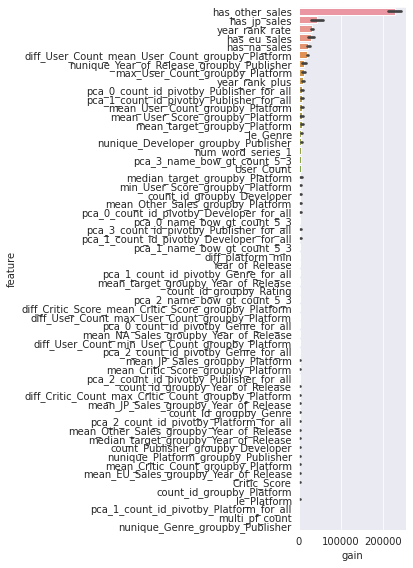

In [19]:
with logger.start(experiment_name=settings['competition'], run_name=settings['name']):
    oof, models, cv, importances = train(
        settings,
        logger,
        df_f_train,
        df_train,
        df_train.loc[:, 'target'].values,
        ckptdir
    )
    preds = predict(models, df_f_test, df_train, df_test)
    sub_df = submit(preds, ckptdir)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


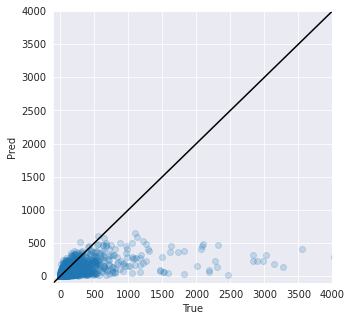

In [20]:
visualize_oof(np.expm1(df_train.loc[:, 'target'].values), np.expm1(oof))